In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import HeNormal, GlorotNormal
import tensorflow as tf

In [8]:
# load dataset
df = pd.read_csv('./data/ml-latest-small/ratings.csv')

In [9]:
# binary implicit feedback
# rating >= 3.0일 경우 positive로 간주
df['rating'] = df['rating'].apply(lambda x: 1 if x >= 3.0 else 0)

# 전체 유저 수와 영화 수
n_users = df.userId.nunique()
n_movies = df.movieId.nunique()

# 데이터를 train/valid로 나눔
train, validation = train_test_split(df, test_size=0.2, random_state=42)

# 유저 아이디 indexing
unique_user_ids = df["userId"].unique()
userId_dict = {id: i for i, id in enumerate(unique_user_ids)}


# 영화 아이디 indexing
unique_movie_ids = df["movieId"].unique()
movieId_dict = {id: i for i, id in enumerate(unique_movie_ids)}

# 인덱싱 된 딕셔너리를 사용하여 ID 맵핑
train["userId"] = train["userId"].map(userId_dict)
train["movieId"] = train["movieId"].map(movieId_dict)

validation["userId"] = validation["userId"].map(userId_dict)
validation["movieId"] = validation["movieId"].map(movieId_dict)

# 전체 유니크 유저 수
num_unique_users = df['userId'].nunique() + 1
# 전체 유니크 영화 수
num_unique_movies = df['movieId'].nunique() + 1

In [10]:
# 유저/아이템 입력 레이어
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

# 임베딩 차원
n_latent_factors = 20

# 임베딩 레이어 정의
user_embedding = Embedding(num_unique_users, n_latent_factors, name='user_embedding')(user_input)
movie_embedding = Embedding(num_unique_movies, n_latent_factors, name='movie_embedding')(movie_input)

# 임베딩 flatten
user_vector = Flatten()(user_embedding)
movie_vector = Flatten()(movie_embedding)

# 유저 및 영화 임베딩 벡터 컨캣
concat = Concatenate()([user_vector, movie_vector])

In [11]:
# MLP 생성하는 함수 -> 원하는 형태로 블록처럼 쌓을 수 있음
def create_mlp(hidden_layers, output):
    for i in range(len(hidden_layers)):
        if i == 0:
            hidden = Dense(hidden_layers[i], activation='relu')(output)
        else:
            hidden = Dense(hidden_layers[i], activation='relu')(hidden)
    output = Dense(1, activation='sigmoid')(hidden)  # 이진 출력은 시그모이드 활성화로
    return output

# create_mlp 함수를 사용하여 MLP 모델 생성
output = create_mlp([64, 64], concat)

In [12]:
# define the model
model = Model(inputs=[user_input, movie_input], outputs=output)

# evaluation
auc = tf.keras.metrics.AUC()

# model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 20)     │     12,220 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 20)     │    194,500 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 20)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 20)        │          0 │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 40)        │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      2,624 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      4,160 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         65 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 213,569 (834.25 KB)

 Trainable params: 213,569 (834.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import matplotlib.pyplot as plt

# loss info table
df = pd.DataFrame(columns=['Optimizer', 'Loss'])

# compile the model
from tensorflow.keras.optimizers import SGD

custom_optimizer_momentum = SGD(learning_rate=0.01, momentum=0.9)
custom_optimizer_nag = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

optimizers = ['sgd', 'adagrad', custom_optimizer_momentum, custom_optimizer_nag, 
              'rmsprop', 'adadelta', 'adam', 'nadam']

# dictionary for loss history
loss_history = {}

for optimizer in optimizers:
    
    # user/item input layer
    user_input = Input(shape=(1,))
    movie_input = Input(shape=(1,))
    
    # embedding dimension
    n_latent_factors = 20
    
    # embedding layers
    user_embedding = Embedding(num_unique_users, n_latent_factors, name='user_embedding')(user_input)
    movie_embedding = Embedding(num_unique_movies, n_latent_factors, name='movie_embedding')(movie_input)
    
    # flatten embeddings
    user_vector = Flatten()(user_embedding)
    movie_vector = Flatten()(movie_embedding)
    
    # concat the embeddings
    concat = Concatenate()([user_vector, movie_vector])
    
    output = create_mlp([64, 64], concat)
    
    # model
    model = Model(inputs=[user_input, movie_input], outputs=output)
    
    # model compile
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', auc])
    
    # fit the model
    history = model.fit([train.userId, train.movieId], train.rating, epochs=10,
                        verbose=2, validation_data=([validation.userId, validation.movieId], validation.rating))
    
    # print loss and accuracy
    print(f"Opimizer: {optimizer}")
    print(f"Loss: {history.history['val_loss'][-1]}")
    print(f"Accuracy: {history.history['accuracy'][-1]}")
    
    df_append = pd.DataFrame(
        {
            'Optimizer': optimizer,
            'Loss' : history.history['val_loss'][-1]
        },
        index=[0]
    )
    
    df = pd.concat([df, df_append], ignore_index=True)
    
    # update the dictionary
    loss_history[str(optimizer)] = history.history['val_loss']

Epoch 1/10


d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_50', 'keras_tensor_51']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 - 2s - 751us/step - accuracy: 0.8108 - auc_1: 0.5913 - loss: 0.4926 - val_accuracy: 0.8091 - val_auc_1: 0.5972 - val_loss: 0.4853
Epoch 2/10
2521/2521 - 1s - 546us/step - accuracy: 0.8113 - auc_1: 0.6214 - loss: 0.4791 - val_accuracy: 0.8091 - val_auc_1: 0.6642 - val_loss: 0.4775
Epoch 3/10
2521/2521 - 1s - 528us/step - accuracy: 0.8113 - auc_1: 0.6794 - loss: 0.4666 - val_accuracy: 0.8091 - val_auc_1: 0.7002 - val_loss: 0.4601
Epoch 4/10
2521/2521 - 1s - 510us/step - accuracy: 0.8131 - auc_1: 0.7110 - loss: 0.4469 - val_accuracy: 0.8127 - val_auc_1: 0.7218 - val_loss: 0.4423
Epoch 5/10
2521/2521 - 1s - 495us/step - accuracy: 0.8168 - auc_1: 0.7310 - loss: 0.4329 - val_accuracy: 0.8156 - val_auc_1: 0.7332 - val_loss: 0.4332
Epoch 6/10
2521/2521 - 1s - 542us/step - accuracy: 0.8187 - auc_1: 0.7430 - loss: 0.4257 - val_accuracy: 0.8155 - val_auc_1: 0.7405 - val_loss: 0.4289
Epoch 7/10
2521/2521 - 1s - 532us/step - accuracy: 0.8194 - auc_1: 0.7524 - loss: 0.4203 - val_accuracy: 

C:\Users\ahn28\AppData\Local\Temp\ipykernel_4056\1312142937.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_append], ignore_index=True)
d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_60', 'keras_tensor_61']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 - 3s - 1ms/step - accuracy: 0.8107 - auc_1: 0.5604 - loss: 0.5640 - val_accuracy: 0.8091 - val_auc_1: 0.5346 - val_loss: 0.5041
Epoch 2/10
2521/2521 - 2s - 823us/step - accuracy: 0.8113 - auc_1: 0.5207 - loss: 0.4889 - val_accuracy: 0.8091 - val_auc_1: 0.5761 - val_loss: 0.4864
Epoch 3/10
2521/2521 - 2s - 810us/step - accuracy: 0.8113 - auc_1: 0.5878 - loss: 0.4821 - val_accuracy: 0.8091 - val_auc_1: 0.6042 - val_loss: 0.4842
Epoch 4/10
2521/2521 - 2s - 815us/step - accuracy: 0.8113 - auc_1: 0.6188 - loss: 0.4800 - val_accuracy: 0.8091 - val_auc_1: 0.6282 - val_loss: 0.4821
Epoch 5/10
2521/2521 - 2s - 865us/step - accuracy: 0.8113 - auc_1: 0.6390 - loss: 0.4778 - val_accuracy: 0.8091 - val_auc_1: 0.6476 - val_loss: 0.4797
Epoch 6/10
2521/2521 - 2s - 839us/step - accuracy: 0.8113 - auc_1: 0.6565 - loss: 0.4750 - val_accuracy: 0.8091 - val_auc_1: 0.6643 - val_loss: 0.4766
Epoch 7/10
2521/2521 - 2s - 836us/step - accuracy: 0.8113 - auc_1: 0.6716 - loss: 0.4717 - val_accuracy: 0.

d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_70', 'keras_tensor_71']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 - 2s - 819us/step - accuracy: 0.8145 - auc_1: 0.6906 - loss: 0.4470 - val_accuracy: 0.8160 - val_auc_1: 0.7528 - val_loss: 0.4252
Epoch 2/10
2521/2521 - 2s - 611us/step - accuracy: 0.8258 - auc_1: 0.7809 - loss: 0.4021 - val_accuracy: 0.8206 - val_auc_1: 0.7863 - val_loss: 0.4061
Epoch 3/10
2521/2521 - 2s - 613us/step - accuracy: 0.8359 - auc_1: 0.8177 - loss: 0.3762 - val_accuracy: 0.8250 - val_auc_1: 0.7933 - val_loss: 0.3967
Epoch 4/10
2521/2521 - 2s - 614us/step - accuracy: 0.8439 - auc_1: 0.8359 - loss: 0.3605 - val_accuracy: 0.8265 - val_auc_1: 0.7951 - val_loss: 0.3967
Epoch 5/10
2521/2521 - 2s - 625us/step - accuracy: 0.8514 - auc_1: 0.8480 - loss: 0.3486 - val_accuracy: 0.8261 - val_auc_1: 0.8003 - val_loss: 0.3971
Epoch 6/10
2521/2521 - 2s - 615us/step - accuracy: 0.8561 - auc_1: 0.8569 - loss: 0.3392 - val_accuracy: 0.8269 - val_auc_1: 0.8005 - val_loss: 0.3950
Epoch 7/10
2521/2521 - 2s - 613us/step - accuracy: 0.8605 - auc_1: 0.8636 - loss: 0.3317 - val_accuracy: 

d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_80', 'keras_tensor_81']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 - 2s - 890us/step - accuracy: 0.8144 - auc_1: 0.7110 - loss: 0.4483 - val_accuracy: 0.8166 - val_auc_1: 0.7585 - val_loss: 0.4195
Epoch 2/10
2521/2521 - 2s - 657us/step - accuracy: 0.8255 - auc_1: 0.7865 - loss: 0.3986 - val_accuracy: 0.8267 - val_auc_1: 0.7877 - val_loss: 0.4007
Epoch 3/10
2521/2521 - 2s - 642us/step - accuracy: 0.8381 - auc_1: 0.8217 - loss: 0.3725 - val_accuracy: 0.8235 - val_auc_1: 0.7935 - val_loss: 0.3988
Epoch 4/10
2521/2521 - 2s - 643us/step - accuracy: 0.8458 - auc_1: 0.8387 - loss: 0.3576 - val_accuracy: 0.8283 - val_auc_1: 0.8005 - val_loss: 0.3925
Epoch 5/10
2521/2521 - 2s - 662us/step - accuracy: 0.8532 - auc_1: 0.8508 - loss: 0.3454 - val_accuracy: 0.8322 - val_auc_1: 0.7996 - val_loss: 0.3916
Epoch 6/10
2521/2521 - 2s - 649us/step - accuracy: 0.8574 - auc_1: 0.8594 - loss: 0.3366 - val_accuracy: 0.8325 - val_auc_1: 0.7994 - val_loss: 0.3975
Epoch 7/10
2521/2521 - 2s - 653us/step - accuracy: 0.8609 - auc_1: 0.8654 - loss: 0.3300 - val_accuracy: 

d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_90', 'keras_tensor_91']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 - 3s - 1ms/step - accuracy: 0.8247 - auc_1: 0.7449 - loss: 0.4251 - val_accuracy: 0.8288 - val_auc_1: 0.7617 - val_loss: 0.4128
Epoch 2/10
2521/2521 - 2s - 858us/step - accuracy: 0.8394 - auc_1: 0.7887 - loss: 0.3905 - val_accuracy: 0.8257 - val_auc_1: 0.7714 - val_loss: 0.4104
Epoch 3/10
2521/2521 - 2s - 860us/step - accuracy: 0.8451 - auc_1: 0.8017 - loss: 0.3794 - val_accuracy: 0.8160 - val_auc_1: 0.7704 - val_loss: 0.4187
Epoch 4/10
2521/2521 - 2s - 876us/step - accuracy: 0.8491 - auc_1: 0.8081 - loss: 0.3728 - val_accuracy: 0.8285 - val_auc_1: 0.7731 - val_loss: 0.4103
Epoch 5/10
2521/2521 - 2s - 852us/step - accuracy: 0.8518 - auc_1: 0.8139 - loss: 0.3673 - val_accuracy: 0.8237 - val_auc_1: 0.7770 - val_loss: 0.4113
Epoch 6/10
2521/2521 - 2s - 876us/step - accuracy: 0.8544 - auc_1: 0.8183 - loss: 0.3623 - val_accuracy: 0.8228 - val_auc_1: 0.7769 - val_loss: 0.4143
Epoch 7/10
2521/2521 - 2s - 858us/step - accuracy: 0.8583 - auc_1: 0.8240 - loss: 0.3570 - val_accuracy: 0.

d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_100', 'keras_tensor_101']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 - 3s - 1ms/step - accuracy: 0.7729 - auc_1: 0.5594 - loss: 0.6847 - val_accuracy: 0.8091 - val_auc_1: 0.4985 - val_loss: 0.6772
Epoch 2/10
2521/2521 - 2s - 959us/step - accuracy: 0.8113 - auc_1: 0.5066 - loss: 0.6682 - val_accuracy: 0.8091 - val_auc_1: 0.5085 - val_loss: 0.6591
Epoch 3/10
2521/2521 - 2s - 945us/step - accuracy: 0.8113 - auc_1: 0.5017 - loss: 0.6488 - val_accuracy: 0.8091 - val_auc_1: 0.5092 - val_loss: 0.6387
Epoch 4/10
2521/2521 - 2s - 968us/step - accuracy: 0.8113 - auc_1: 0.5112 - loss: 0.6275 - val_accuracy: 0.8091 - val_auc_1: 0.5138 - val_loss: 0.6171
Epoch 5/10
2521/2521 - 2s - 970us/step - accuracy: 0.8113 - auc_1: 0.5093 - loss: 0.6055 - val_accuracy: 0.8091 - val_auc_1: 0.5147 - val_loss: 0.5954
Epoch 6/10
2521/2521 - 2s - 910us/step - accuracy: 0.8113 - auc_1: 0.5114 - loss: 0.5841 - val_accuracy: 0.8091 - val_auc_1: 0.5183 - val_loss: 0.5747
Epoch 7/10
2521/2521 - 2s - 919us/step - accuracy: 0.8113 - auc_1: 0.5078 - loss: 0.5641 - val_accuracy: 0.

d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_110', 'keras_tensor_111']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 - 3s - 1ms/step - accuracy: 0.8263 - auc_1: 0.7299 - loss: 0.4077 - val_accuracy: 0.8302 - val_auc_1: 0.7987 - val_loss: 0.3918
Epoch 2/10
2521/2521 - 2s - 756us/step - accuracy: 0.8500 - auc_1: 0.8448 - loss: 0.3496 - val_accuracy: 0.8328 - val_auc_1: 0.7985 - val_loss: 0.3929
Epoch 3/10
2521/2521 - 2s - 755us/step - accuracy: 0.8656 - auc_1: 0.8736 - loss: 0.3186 - val_accuracy: 0.8303 - val_auc_1: 0.7949 - val_loss: 0.4161
Epoch 4/10
2521/2521 - 2s - 756us/step - accuracy: 0.8759 - auc_1: 0.8923 - loss: 0.2958 - val_accuracy: 0.8243 - val_auc_1: 0.7878 - val_loss: 0.4255
Epoch 5/10
2521/2521 - 2s - 759us/step - accuracy: 0.8845 - auc_1: 0.9086 - loss: 0.2743 - val_accuracy: 0.8194 - val_auc_1: 0.7824 - val_loss: 0.4505
Epoch 6/10
2521/2521 - 2s - 815us/step - accuracy: 0.8939 - auc_1: 0.9225 - loss: 0.2536 - val_accuracy: 0.8201 - val_auc_1: 0.7641 - val_loss: 0.4639
Epoch 7/10
2521/2521 - 2s - 804us/step - accuracy: 0.9030 - auc_1: 0.9361 - loss: 0.2313 - val_accuracy: 0.

d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_120', 'keras_tensor_121']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 - 3s - 1ms/step - accuracy: 0.8264 - auc_1: 0.7563 - loss: 0.4079 - val_accuracy: 0.8327 - val_auc_1: 0.8028 - val_loss: 0.3887
Epoch 2/10
2521/2521 - 2s - 819us/step - accuracy: 0.8513 - auc_1: 0.8465 - loss: 0.3481 - val_accuracy: 0.8343 - val_auc_1: 0.8036 - val_loss: 0.3910
Epoch 3/10
2521/2521 - 2s - 818us/step - accuracy: 0.8663 - auc_1: 0.8741 - loss: 0.3175 - val_accuracy: 0.8333 - val_auc_1: 0.7986 - val_loss: 0.4022
Epoch 4/10
2521/2521 - 2s - 815us/step - accuracy: 0.8774 - auc_1: 0.8947 - loss: 0.2922 - val_accuracy: 0.8221 - val_auc_1: 0.7913 - val_loss: 0.4269
Epoch 5/10
2521/2521 - 2s - 817us/step - accuracy: 0.8877 - auc_1: 0.9099 - loss: 0.2708 - val_accuracy: 0.8199 - val_auc_1: 0.7779 - val_loss: 0.4390
Epoch 6/10
2521/2521 - 2s - 814us/step - accuracy: 0.8979 - auc_1: 0.9238 - loss: 0.2493 - val_accuracy: 0.8199 - val_auc_1: 0.7772 - val_loss: 0.4638
Epoch 7/10
2521/2521 - 2s - 813us/step - accuracy: 0.9081 - auc_1: 0.9371 - loss: 0.2265 - val_accuracy: 0.

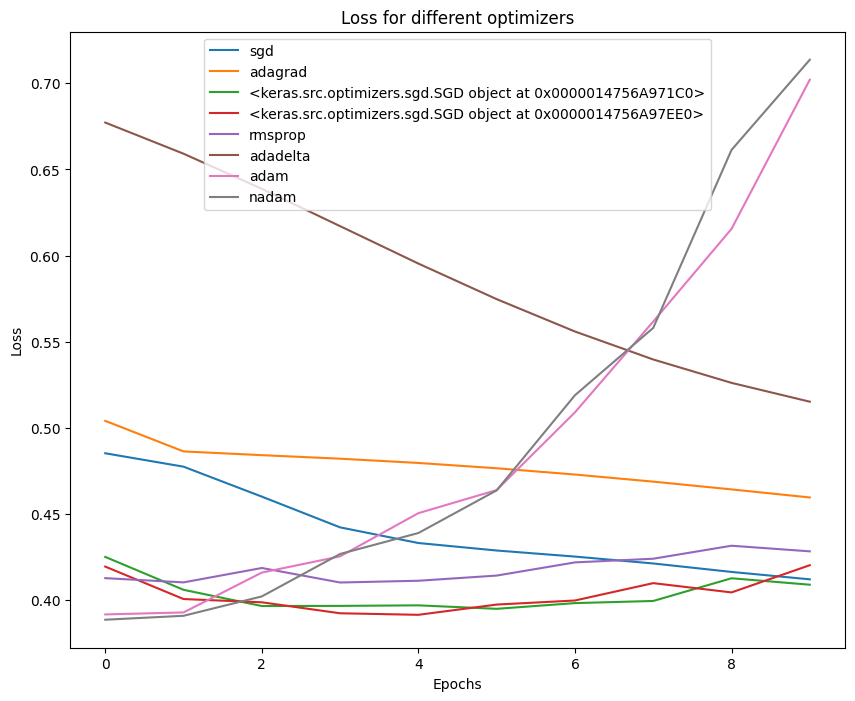

In [19]:
# loss plot graph
plt.figure(figsize=(10, 8))

for optimizer, losses in loss_history.items():
    plt.plot(losses, label=optimizer)

plt.title('Loss for different optimizers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
display(df)

,Optimizer,Loss
0,sgd,0.412147
1,adagrad,0.459651
2,<keras.src.optimizers.sgd.SGD object at 0x0000...,0.409026
3,<keras.src.optimizers.sgd.SGD object at 0x0000...,0.420342
4,rmsprop,0.428389
5,adadelta,0.515214
6,adam,0.702054
7,nadam,0.713631
